# ISPR Midterm 3 Assignment 1 - Alessandro Bucci 638619

Train 1 denoising and 1 contractive autoencoder on the MNIST dataset. It is up to you to decide how many layers and neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different autoencoders.

Then, experiment with what happens if you feed the autoencoders with a random noise image and then you apply the iterative gradient ascent process described in the lecture to see if the reconstruction converges to the data manifold. Confront the reconstructions created by the 2 different models and comment on the results.

## Code

### Importing libraries

In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
rc('animation', html='html5')

import numpy as np
from IPython.display import HTML


Checking if cuda is available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Choosing batch size

In [3]:
batch_size = 128

Loading datasets

In [4]:
data_transform = transforms.Compose(
        [
            transforms.ToTensor(), 
            #transforms.Normalize(mean=(0.1307,), std=(0.3081,)) # already normalized dataset
        ]
    )

train_ds = datasets.MNIST('data', train=True, download=True,
                          transform=data_transform)
test_ds = datasets.MNIST('data', train=False, 
                         transform=data_transform)


train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_ds,
                                          batch_size=batch_size, 
                                          shuffle=True)


Establishing base AE architecture

In [5]:
class AE(nn.Module):
    def __init__(self, type = 'default'):
      super(AE, self).__init__()
      self.el1 = nn.Linear(28*28, 400, bias = False) # Encoder
      self.dl1 = nn.Linear(400, 28*28, bias = False) # Decoder
      
      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()


    def encoder(self, x):
      enc = self.el1(x.view(-1, 28*28)) # making sure that each image is an array
      enc = self.relu(enc)
      return enc

    def decoder(self,encoding):
      dec = self.dl1(encoding)
      dec = self.sigmoid(dec)
      return dec

    def forward(self, x):
      encoding = self.encoder(x)
      reconstruction = self.decoder(encoding)
      return encoding, reconstruction          

### Denoising Autoencoder

In [6]:
dae_model = AE()
optimizer = optim.Adam(dae_model.parameters(), lr = 0.0001)
loss_function = nn.MSELoss()
noise_factor = 0.5

if torch.cuda.is_available():
    dae_model = dae_model.cuda()

Defining the noinsing function

In [7]:
torch.seed()

def noise(data, noisiness = 0.5):
    noise = torch.rand(data.shape)
    
    if torch.cuda.is_available():
        noise = noise.cuda()
        
    if noisiness >= 0 and noisiness <= 1:
        noisy_data = ((1-noisiness) * data) + (noisiness * noise)
    else:
        noisy_data = .5*data + .5*noise
    
    return noisy_data

In [8]:
def train(epoch):
    dae_model.train()
    train_loss = 0

    for idx, (data, _) in enumerate(train_loader):
        
        data = Variable(data) #Inserting the data in the computational graph for autograd
        
        if torch.cuda.is_available():
            data = data.cuda()

        optimizer.zero_grad()

        hidden_representation, recon = dae_model.forward(noise(data, noise_factor))

        loss = loss_function(data.view(-1,28*28), recon)

        loss.backward()
        train_loss += loss
        optimizer.step()

        if idx % 100 == 0:
            print('Train epoch: {} [{}/{}({:.0f}%)]\t Loss: {:.6f}'.format(
                  epoch, idx*len(data), len(train_loader.dataset),
                  100*idx/len(train_loader),
                  loss.data/len(data)))


    print('====> Epoch: {} Average loss: {:.8f}'.format(
         epoch, train_loss / len(train_loader.dataset)))

for epoch in range(5):
    train(epoch)

Train epoch: 0 [0/60000(0%)]	 Loss: 0.001812
Train epoch: 0 [12800/60000(21%)]	 Loss: 0.000538
Train epoch: 0 [25600/60000(43%)]	 Loss: 0.000508
Train epoch: 0 [38400/60000(64%)]	 Loss: 0.000490
Train epoch: 0 [51200/60000(85%)]	 Loss: 0.000462
====> Epoch: 0 Average loss: 0.00058095
Train epoch: 1 [0/60000(0%)]	 Loss: 0.000414
Train epoch: 1 [12800/60000(21%)]	 Loss: 0.000399
Train epoch: 1 [25600/60000(43%)]	 Loss: 0.000352
Train epoch: 1 [38400/60000(64%)]	 Loss: 0.000331
Train epoch: 1 [51200/60000(85%)]	 Loss: 0.000310
====> Epoch: 1 Average loss: 0.00035348
Train epoch: 2 [0/60000(0%)]	 Loss: 0.000295
Train epoch: 2 [12800/60000(21%)]	 Loss: 0.000287
Train epoch: 2 [25600/60000(43%)]	 Loss: 0.000274
Train epoch: 2 [38400/60000(64%)]	 Loss: 0.000240
Train epoch: 2 [51200/60000(85%)]	 Loss: 0.000238
====> Epoch: 2 Average loss: 0.00026827
Train epoch: 3 [0/60000(0%)]	 Loss: 0.000256
Train epoch: 3 [12800/60000(21%)]	 Loss: 0.000226
Train epoch: 3 [25600/60000(43%)]	 Loss: 0.000225


In [9]:
torch.no_grad()

Checking if the model works:

In [10]:
rand_ids = []
for i in range(10):
    rand_ids.append(np.int32(np.random.rand()*len(train_ds)))

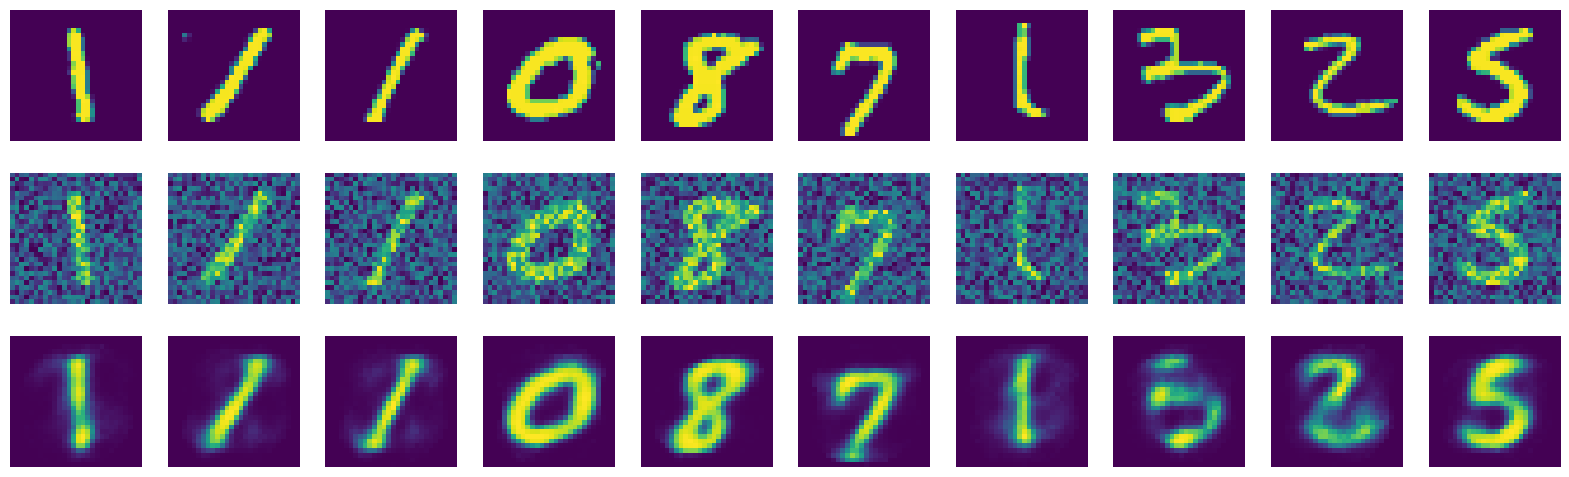

In [11]:
fig, axs = plt.subplots(3, 10)
fig.set_figwidth(20)
fig.set_figheight(6)

for i, id in enumerate(rand_ids):
    data, label = train_ds[id]
    axs[0, i].imshow(np.transpose(data, (1, 2, 0)), interpolation='nearest')
    axs[0, i].axis('off')
    
    noisy_image = noise(data.cuda(),noise_factor)
    noisy_image = noisy_image.detach().cpu().view(-1,28,28)
    axs[1, i].imshow(np.transpose(noisy_image, (1, 2, 0)), interpolation='nearest')
    axs[1, i].axis('off')
    
    _ , recon = dae_model.forward(noisy_image.cuda())
    recon = recon.detach().cpu().view(-1,28,28)
    axs[2, i].imshow(np.transpose(recon, (1, 2, 0)), interpolation='nearest')
    axs[2, i].axis('off')

plt.show()

### Contractive Autoencoder


The contractive term is defined as: \
![alt text](FrobeniusContractive.svg "Frobenius wrt weights derivation")

In [12]:
def contractive_loss(x, recons_x, W, h, lam):
    L = nn.MSELoss() #for simplicity
    loss = L(recons_x, x)
    
    # Since: W is shape of N_hidden x N. So, we do not need to transpose it
    
    dh = h * (1 - h) # Product produces size N_batch x N_hidden
    
    # Sum through the input dimension to improve efficiency, as suggested in #1
    w_sum = torch.sum(Variable(W)**2, dim=1)
    
    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1 (for each hidden neuron there is a sum over its weights)
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return loss + contractive_loss.mul_(lam)

In [13]:
cae_model = AE()
optimizer = optim.Adam(cae_model.parameters(), lr = 0.0001)
loss_function = contractive_loss
lam = 0.00001 #lambda

if torch.cuda.is_available():
    cae_model = cae_model.cuda()

In [14]:
def train(epoch):
    cae_model.train()
    train_loss = 0

    for idx, (data, _) in enumerate(train_loader):
        
        data = Variable(data) #Inserting the data in the computational graph for autograd
        
        if torch.cuda.is_available():
            data = data.cuda()

        optimizer.zero_grad()

        hidden_representation, recon = cae_model.forward(data)
        enc_weights = cae_model.state_dict()['el1.weight']
        loss = loss_function(data.view(-1,28*28), recon, enc_weights, hidden_representation, lam)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()

        if idx % 100 == 0:
            print('Train epoch: {} [{}/{}({:.0f}%)]\t Loss: {:.6f}'.format(
                  epoch, idx*len(data), len(train_loader.dataset),
                  100*idx/len(train_loader),
                  loss.data[0]/len(data))) # loss / batch size


    print('====> Epoch: {} Average loss: {:.10f}'.format(
         epoch, train_loss / len(train_loader.dataset)))

for epoch in range(5):
    train(epoch)

Train epoch: 0 [0/60000(0%)]	 Loss: 0.001822
Train epoch: 0 [12800/60000(21%)]	 Loss: 0.000633
Train epoch: 0 [25600/60000(43%)]	 Loss: 0.000529
Train epoch: 0 [38400/60000(64%)]	 Loss: 0.000469
Train epoch: 0 [51200/60000(85%)]	 Loss: 0.000428
====> Epoch: 0 Average loss: 0.0006326112
Train epoch: 1 [0/60000(0%)]	 Loss: 0.000415
Train epoch: 1 [12800/60000(21%)]	 Loss: 0.000381
Train epoch: 1 [25600/60000(43%)]	 Loss: 0.000342
Train epoch: 1 [38400/60000(64%)]	 Loss: 0.000346
Train epoch: 1 [51200/60000(85%)]	 Loss: 0.000331
====> Epoch: 1 Average loss: 0.0003519034
Train epoch: 2 [0/60000(0%)]	 Loss: 0.000308
Train epoch: 2 [12800/60000(21%)]	 Loss: 0.000292
Train epoch: 2 [25600/60000(43%)]	 Loss: 0.000299
Train epoch: 2 [38400/60000(64%)]	 Loss: 0.000278
Train epoch: 2 [51200/60000(85%)]	 Loss: 0.000263
====> Epoch: 2 Average loss: 0.0002842489
Train epoch: 3 [0/60000(0%)]	 Loss: 0.000284
Train epoch: 3 [12800/60000(21%)]	 Loss: 0.000250
Train epoch: 3 [25600/60000(43%)]	 Loss: 0.0

Checking if the model works:

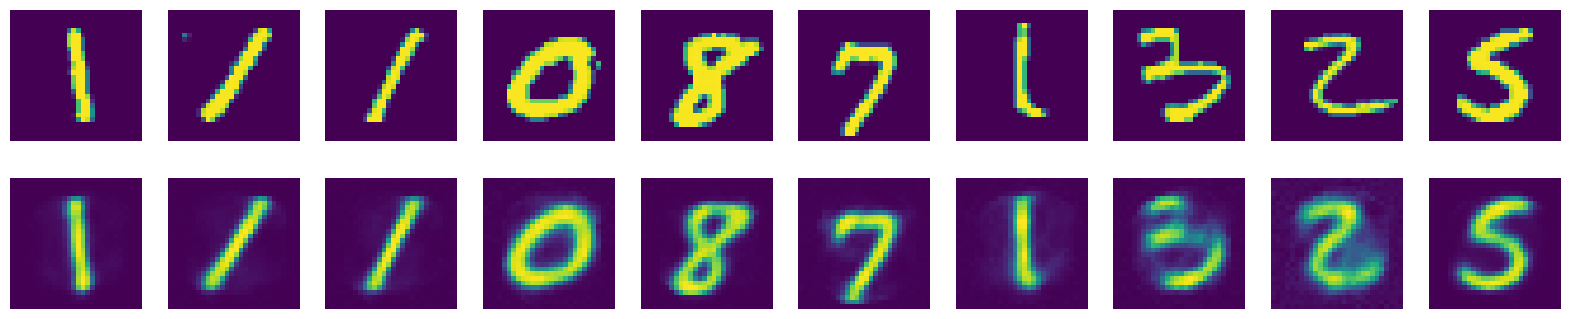

In [15]:
fig, axs = plt.subplots(2, 10)
fig.set_figwidth(20)
fig.set_figheight(4)

for i, id in enumerate(rand_ids):
    data, label = train_ds[id]
    axs[0, i].imshow(np.transpose(data, (1, 2, 0)), interpolation='nearest')
    axs[0, i].axis('off')
    
    _ , recon = cae_model.forward(data.cuda())
    recon = recon.detach().cpu().view(-1,28,28)
    axs[1, i].imshow(np.transpose(recon, (1, 2, 0)), interpolation='nearest')
    axs[1, i].axis('off')

plt.show()

## Random noise feeding

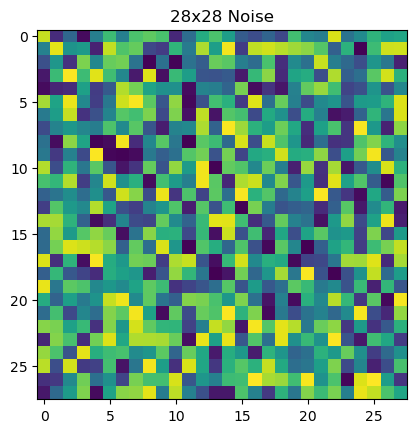

In [16]:
torch.manual_seed(42)
torch.seed()
random_noise = torch.rand(data.shape)
plt.imshow(np.transpose(random_noise, (1, 2, 0)), interpolation='nearest')
plt.title("28x28 Noise")
plt.show()

In [17]:
print("Gradient ascent DAE")

dae_array = []
image = random_noise.cuda().view(-1,28*28)
dae_array.append(np.transpose(image.detach().cpu().view(-1,28,28), (1, 2, 0)))
mae = nn.L1Loss() #using torch mae to get the element-wise difference between reconstruction 
max_iters = 1000

for i in range(max_iters):
    (_, recon) = dae_model.forward(image)
    difference = mae(recon, image)
    image=recon
    
    dae_array.append(np.transpose(image.detach().cpu().view(-1,28,28), (1, 2, 0)))
    
    if difference < 0.0001:
        break
    else:
        print(difference)
        
recon_dae = recon


Gradient ascent DAE
tensor(0.5155, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4849, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4835, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4840, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4835, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4827, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4814, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4810, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4799, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4783, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4778, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4762, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4755, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4724, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.46

In [18]:
print("Gradient ascent CAE")

cae_array = []
image = random_noise.cuda().view(-1,28*28)
cae_array.append(np.transpose(image.detach().cpu().view(-1,28,28), (1, 2, 0)))
max_iters = 1000

for i in range(max_iters):
    (_, recon) = cae_model.forward(image)
    difference = mae(recon, image)
    image=recon
    
    cae_array.append(np.transpose(image.detach().cpu().view(-1,28,28), (1, 2, 0)))

    if difference < 0.0001:
        break
    else:
        print(difference)
        
recon_cae = recon
        

Gradient ascent CAE
tensor(0.5166, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4247, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4202, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3852, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3241, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3179, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2857, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2588, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1947, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1357, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.10

In [19]:
def generate_gif(array, gif_name='movie'):
    fig = plt.figure()
    plt.axis("off")
    
    frames = [] 
    for i in range(len(array)):
        frames.append((plt.imshow(array[i], animated=True),))
    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=False, repeat_delay=1000, repeat=True)
    ani.save(gif_name + '.gif')
    plt.close()
    return ani

In [20]:
generate_gif(dae_array, 'dae')

In [21]:
generate_gif(cae_array, 'cae')

## DAE Analysis

I have tried for different noise values in the DAE and I observed the following behaviours:
- For noisiness = 0.1, during the learning phase the loss will be smaller but it won't recostruct well images noisier than the ones it was trained to denoise. The images with the same noise are well reconstructed. It won't converge in the gradient ascent (Probably since it is not robust enough to discern a full noisy image).
- For noisiness between 0.2 and 0.4 the images with same noise are well reconstructed. In the gradient ascent there will not be any convergence but where with noisiness=0.1 the two images that the gradient ascent was alternating where unstructured, here appears to be a more omogeneous structure in one of the 2 images, like a cloud with a point in the middle.
- For noisiness = 0.5 the reconstructions are cloudier whilst during the gradient ascent at the beginning it alternates back and forth between two images as with noisiness = 0.2 but after a while it converges into a filled circle.
- For noisiness = 0.6 the reconstructions are even cloudier but still recognizable. The gradient ascent converges to a sort of a sideways 8.
- For noisiness = 0.7, the reconstructions from images is getting worse but some numbers are more recognizable than other and at times the reconstructions can include pieces that where not there before (e.g a 5 could become partly a 8 and a 8 could become parlty an 3). In the gradient ascent there is convergence first towards an image that resemble an diagonal 8 and then it morphs into a 0.
- For noisiness = 0.8 the reconstructions sometimes does not align at all from the image they came from, for lower noise reconstructions is a little better but very granier. The convergence is toward a zero and is very quick.
- For noisiness = 0.9 the reconstructions will be grainier and unrecognizable from before almost getting the same image, this is also the case in the gradient ascent. But in gradient ascent the convergence towards a 0 is very fast this is probably to the fact that the model has learned to reconstruct almost full noise images in one passage.

The animations for the convergences can be found below

### DAE different noisiness convergence animations

#### Noisiness = 0.1
![SegmentLocal](dae01.gif "Noisiness = 0.1")\
#### Noisiness = 0.2
![SegmentLocal](dae02.gif "Noisiness = 0.2")\
#### Noisiness = 0.3
![SegmentLocal](dae03.gif "Noisiness = 0.3")\
#### Noisiness = 0.4
![SegmentLocal](dae04.gif "Noisiness = 0.4")\
#### Noisiness = 0.5
![SegmentLocal](dae05.gif "Noisiness = 0.5")\
#### Noisiness = 0.6
![SegmentLocal](dae06.gif "Noisiness = 0.6")\
#### Noisiness = 0.7
![SegmentLocal](dae07.gif "Noisiness = 0.7")\
#### Noisiness = 0.8
![SegmentLocal](dae08.gif "Noisiness = 0.8")\
#### Noisiness = 0.9
![SegmentLocal](dae09.gif "Noisiness = 0.9")\


## CAE Analysis

I have also tried for different values of lambda in the CAE and I observed the following behaviours:
- For higher lambdas the loss does not decrase and the reconstructions are blanks or noise.
- For lambda = 1e-3 the loss decreases but the reconstructions will be the same for different images and different numbers. It does not manage to converge during the gradient ascend by alternating back and forth between two images where one has slightly lighter pixels that the other, resulting in a blinking in the gif generated.
- For lambda = 1e-4 the loss decreases and the reconstructions are different and accurate enough. It does manage to converge to a sort of an average between all the numbers, or at leas something that resemble a mixture of a 0, 8 and 3
- For lambda = 1e-5 the loss decreases and the reconstructions are more accurate. It does converge into a sort of a 0 with a line in the middle, starting from a point in the upper center of the image.
- For lambda = 1e-6 the loss decreases and the reconstructions are more accurate than before. It does converge but it is very slow such that even in 1000 iterations it stills has not properly converged but is going back and forth between two images.
- Lower lambdas are showing the same beaviour as lambda = 1e-6

The animation of the convergences can be found below

### CAE Different lambda convergence animations



#### Lambda = 1e-3
![SegmentLocal](cae1e-03.gif "Lambda = 1e-3")\
#### Lambda = 1e-4
![SegmentLocal](cae1e-04.gif "Lambda = 1e-4")\
#### Lambda = 1e-5
![SegmentLocal](cae1e-05.gif "Lambda = 1e-5")\
#### Lambda = 1e-6
![SegmentLocal](cae1e-06.gif "Lambda = 1e-6")\
#### Lambda = 1e-7
![SegmentLocal](cae1e-07.gif "Lambda = 1e-7")\


## Comparision between CAE and DAE in gradient ascent

The main similarity that I've noticed are that the behaviour of the 2 models are quite similar when there is a noise smaller than 0.5 and for lambda smaller than 1e-5, in the sense that they are not converging but simply alternating between two images, in my opinion in that case they are "orbiting" the manifold without proper convergence due to the traslation in space given by the vectors of the manifold (applied at each reconstruction) that makes the reconstruction "jumps" between two points. \
Then with values "in the middle" for the noisiness and lambda respectively the models begins to differs: the DAE always try to reconstruct a number or something similar to a defined digit whilst the DAE tend to converge to an average of all the digits.\
Lastly, with higher values for the noisiness and lambda respectively the models operates very differently: the DAE converges really fast due to the fact that it has learned to reconstuct images from almost full noise whilst the CAE is too penalized into the encoding that it does not learn anymore, probably because the embeddings given by the encoder of the images becomes too similar to each other.